## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
# path = untar_data(URLs.CAMVID)
# path.ls()

In [4]:
# path_lbl = path/'labels'
# path_img = path/'images'

## Subset classes

In [5]:
path_img = Path('./data/footprint/input')
path_lbl = Path('./data/footprint/gt_bw')
path_img, path_lbl 

(PosixPath('data/footprint/input'), PosixPath('data/footprint/gt_bw'))

### Verify INPUT and LABEL Images in the folder (random)

In [6]:
img_names = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
img_names[0], lbl_names[0]

(PosixPath('data/footprint/input/image_16037.tif'),
 PosixPath('data/footprint/gt_bw/image_1000_gt.tif'))

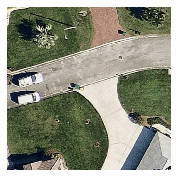

In [7]:
img = open_image(img_names[0])
img.show(figsize=(3,3))

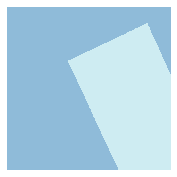

In [8]:
lbl_img = open_mask(lbl_names[0])
lbl_img.show(figsize=(3,3))

### Verify Input and Label Image  (specific input and its label image check)

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_gt{x.suffix}'

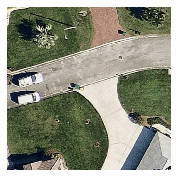

In [10]:
img = open_image(img_names[0])
img.show(figsize=(3,3))

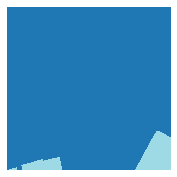

In [11]:

inp_lbl_img = get_y_fn(img_names[0])
mask_img = open_mask(inp_lbl_img)    #We can use 'open_img' / 'open_mask'
mask_img.show(figsize=(3,3), alpha=1)

In [12]:
mask_img.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]]])

In [13]:
np.unique(mask_img.data)

array([0, 1])

In [14]:
inp_lbl_img

PosixPath('data/footprint/gt_bw/image_16037_gt.tif')

### Create ImageDataBunch object 

In [15]:
img_size = 512
bs = 8
codes = array(['None', 'Building'])
# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

src = (SegmentationItemList.from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=codes))
src
#        .label_from_func(get_y_fn))
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
data = (src.transform(get_transforms(), size=img_size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [16]:
data.classes

array(['None', 'Building'], dtype='<U8')

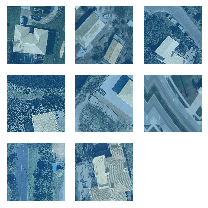

In [17]:
data.show_batch(rows=3, figsize=(3, 3))

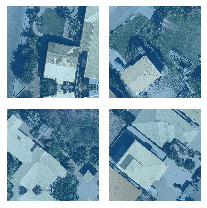

In [18]:
data.show_batch(2, figsize=(3,3), ds_type=DatasetType.Valid)

### Verify the ImageDataBunch object -> Data 

In [19]:
type(data)

fastai.vision.data.ImageDataBunch

### Verify Input image (X) exist in ImageDataBunch object -> data

In [20]:
data.train_dl

DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x7f80cb7c2278>, device=device(type='cuda'), tfms=[functools.partial(<function _normalize_batch at 0x7f80ccac48c8>, mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]), do_x=True, do_y=False)], collate_fn=<function data_collate at 0x7f80d44b2bf8>)

In [21]:
data.train_dl.x

SegmentationItemList (12572 items)
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: data/footprint/input

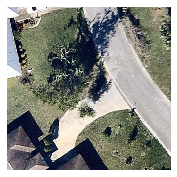

In [22]:
img = data.train_dl.x[0]
img.show(figsize=(3,3))

### Verify Label image (Y) exist in ImageDataBunch object -> data

In [23]:
data.train_dl.y

SegmentationLabelList (12572 items)
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/footprint/input

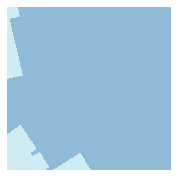

In [24]:
img1 = data.train_dl.y[0]
img1.show(figsize=(3,3))

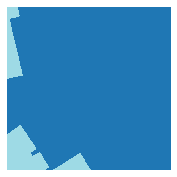

In [25]:
img1.show(figsize=(3,3), alpha=1)

### change 'label' as binary

In [26]:
np.unique(data.train_dl.y[0].data)

array([0, 1])

In [27]:
img = data.train_dl.y[0]
img.data

tensor([[[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]])

In [28]:
data.valid_dl.x

SegmentationItemList (3143 items)
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: data/footprint/input

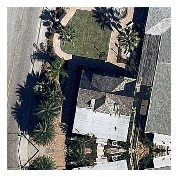

In [29]:
img_v1 = data.valid_ds.x[0]
img_v1.show(figsize=(3,3))

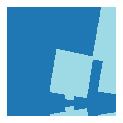

In [30]:
img_v2 = data.valid_ds.y[0]
img_v2.show(figsize=(2,2), alpha=1)

### Run Model Code

In [31]:
wd=1e-2

In [32]:
def acc_camvid(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1) == target).float().mean()

# def acc_camvid(input, target):
#     target = target.squeeze(1)
# #     mask = target != void_code
#     return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [33]:
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# learn = unet_learner(data, models.resnet34, wd=wd)
learn = unet_learner(data, models.resnet34, metrics=acc_camvid, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ec2-user/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 50.9MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


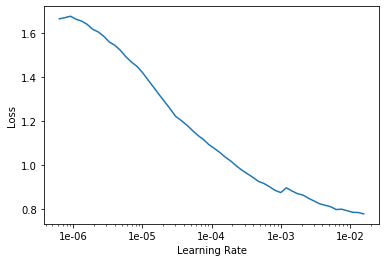

In [34]:
lr_find(learn)
learn.recorder.plot()

# FAST AI code

## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

## Datasets

In [ ]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10,7))

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics=acc_camvid
# metrics=accuracy

In [ ]:
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [ ]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

In [ ]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('stage-2');

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=1e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

In [ ]:
learn.save('stage-1-big')

In [ ]:
learn.load('stage-1-big');

In [ ]:
learn.unfreeze()

In [ ]:
lrs = slice(1e-6,lr/10)

In [ ]:
learn.fit_one_cycle(10, lrs)

In [ ]:
learn.save('stage-2-big')

In [ ]:
learn.load('stage-2-big');

In [ ]:
learn.show_results(rows=3, figsize=(10,10))

## fin